In [3]:
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications import VGG16 

In [4]:
dataset_path = './dataset/'
train_path = './images/train/'
validation_path = './images/validation/'
test_path = './images/test/'
augmented_path = './images/augmented/'
WIDTH = 76
HEIGHT = 76
NO_CLASSES = 11

#### Divide images for training and testing

In [24]:
if train_path not in os.listdir('./images/'):
    os.mkdir(train_path)

if test_path not in os.listdir('./images/'):
    os.mkdir(test_path)

if validation_path not in os.listdir('./images/'):
    os.mkdir(validation_path)

if augmented_path not in os.listdir('./images/'):
    os.mkdir(augmented_path)

In [25]:
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    folder_train_path = os.path.join(train_path, folder)
    folder_validation_path = os.path.join(validation_path, folder)
    folder_test_path = os.path.join(test_path, folder)
    
    folder_images_count = len(os.listdir(folder_path))

    # Create train, validation and test folders
    if folder not in os.listdir(train_path):
        os.mkdir(folder_train_path)
    if folder not in os.listdir(validation_path):
        os.mkdir(folder_validation_path)
    if folder not in os.listdir(test_path):
        os.mkdir(folder_test_path)


    # Create thresholds for dividing images in folders
    image_counter = 0
    train_threshold = folder_images_count * 0.6
    validation_threshold = train_threshold + (folder_images_count * 0.2) 
    test_threshold = validation_threshold + (folder_images_count * 0.2)

    # Save original images into folders
    image_path = ''
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        resized_image = cv2.imread(image_path)

        if isinstance(resized_image, type(None)):
            continue

        resized_image = cv2.resize(resized_image, (WIDTH, HEIGHT))

        if image_counter <= train_threshold:
            cv2.imwrite(os.path.join(folder_train_path, image), resized_image)
        elif image_counter >= train_threshold and image_counter < validation_threshold: 
            cv2.imwrite(os.path.join(folder_validation_path, image), resized_image)
        elif image_counter >= validation_threshold and image_counter < test_threshold:
            cv2.imwrite(os.path.join(folder_test_path, image), resized_image)

        image_counter += 1


#### Data Augmentation

In [5]:
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 40,
							width_shift_range = 0.2,
							height_shift_range = 0.2,
							shear_range = 0.3,
							zoom_range = 0.3,
							horizontal_flip = True,)
							

Found 4124 images belonging to 11 classes.
[ 0  0  0 ... 10 10 10]


<Figure size 432x288 with 0 Axes>

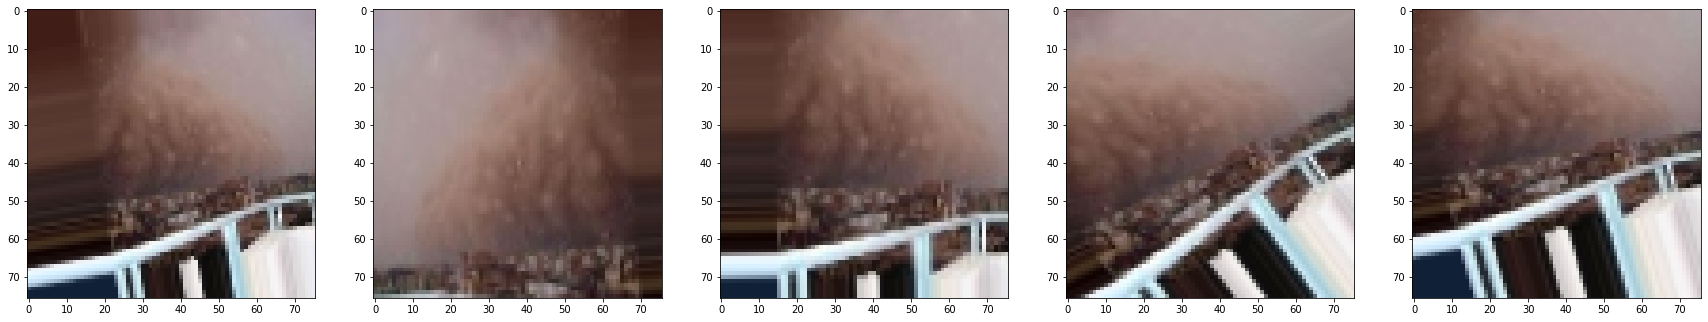

In [6]:
train_generator = train_datagen.flow_from_directory(
							train_path,
							target_size = (WIDTH, HEIGHT),
							batch_size = 8,
							class_mode ='categorical',)

print(train_generator.classes)

plt.figure()
f, axarr = plt.subplots(1, 5, figsize=(30, 8)) 

for i in range(5):
	axarr[i].imshow(train_generator[0][0][0])

Found 4124 images belonging to 11 classes.
(8, 76, 76, 3)
{'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}
4124


<Figure size 432x288 with 0 Axes>

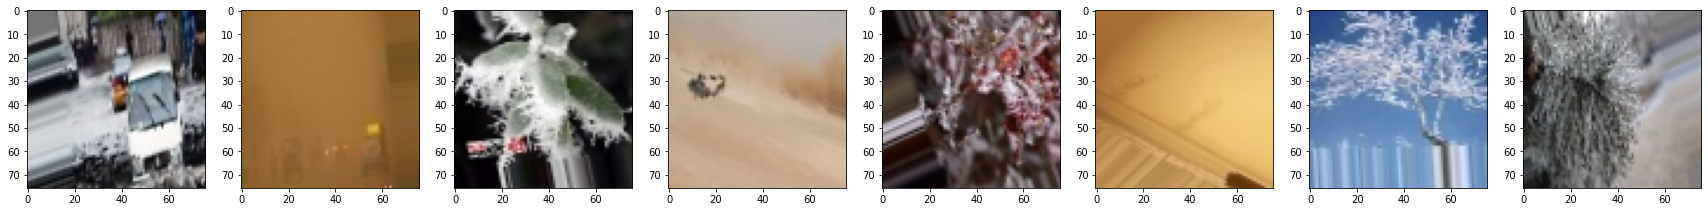

In [7]:
train_generator = train_datagen.flow_from_directory(
							train_path,
							target_size = (WIDTH, HEIGHT),
							batch_size = 8,
							class_mode ='categorical')

images, labels = train_generator[0]

print(images.shape)
print(train_generator.class_indices)
# Got the same amount of classes of the images. Each class has an ID mapped to the value of the class (dew, fogsmog, ..., snow)
print(len(train_generator.classes))

plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4)) 

for i in range(images.shape[0]):  
	axarr[i].imshow(images[i])

In [7]:
# Won't save augmented images
train_generator = train_datagen.flow_from_directory(
							train_path,
							target_size = (WIDTH, HEIGHT),
							batch_size = 8,
							class_mode ='categorical',
							save_to_dir= augmented_path,   
                            save_prefix='aug',
                            save_format='png'
							)

Found 4124 images belonging to 11 classes.


In [8]:
conv_base= VGG16(weights='imagenet',
                    include_top = False,
					input_shape = (WIDTH,HEIGHT,3))

#### Convolutional Neural Network

In [9]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
# model.add(layers.Flatten())
# Tendremos 10 kernels 3x3 que produciran como 10 patrones 
# model.add(layers.Conv2D(10, (3, 3), activation="relu", input_shape = (WIDTH,HEIGHT,3)))
# Aplanamos las 10 matrices en un array 1D para conectarlo con las neuronas del siguiente nivel
model.add(layers.Flatten())
# 64 neuronas. Cada una conectada a cada espacio del array (como pixel de la matriz) y a las 11 de salida
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(11, activation='sigmoid'))

conv_base.trainable = False

model.summary()

model.compile(loss='categorical_crossentropy',
						optimizer='Adam',
						metrics=['acc'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dense_1 (Dense)              (None, 11)                715       
Total params: 14,846,539
Trainable params: 131,851
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
validation_datagen = ImageDataGenerator(1./255)

validation_generator = validation_datagen.flow_from_directory(
							validation_path,
							target_size = (WIDTH,HEIGHT),
							batch_size = 8,
							class_mode= 'categorical')

Found 1369 images belonging to 11 classes.


c:\Users\Rafael\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
80/80 [==============================] - ETA: 0s - loss: 2.2676 - acc: 0.2225

c:\Users\Rafael\AppData\Local\Programs\Python\Python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


80/80 [==============================] - 33s 399ms/step - loss: 2.2649 - acc: 0.2232 - val_loss: 9.6634 - val_acc: 0.4688
Epoch 2/15
80/80 [==============================] - 38s 470ms/step - loss: 1.5843 - acc: 0.4673 - val_loss: 14.4782 - val_acc: 0.4531
Epoch 3/15
80/80 [==============================] - 35s 440ms/step - loss: 1.4433 - acc: 0.5194 - val_loss: 22.5764 - val_acc: 0.4688
Epoch 4/15
80/80 [==============================] - 38s 479ms/step - loss: 1.3522 - acc: 0.5369 - val_loss: 19.7318 - val_acc: 0.4531
Epoch 5/15
80/80 [==============================] - 35s 441ms/step - loss: 1.2501 - acc: 0.5978 - val_loss: 23.8400 - val_acc: 0.4531
Epoch 6/15
80/80 [==============================] - 38s 475ms/step - loss: 1.2343 - acc: 0.5607 - val_loss: 28.2182 - val_acc: 0.3594
Epoch 7/15
80/80 [==============================] - 34s 426ms/step - loss: 1.1090 - acc: 0.5833 - val_loss: 12.3406 - val_acc: 0.6406
Epoch 8/15
80/80 [==============================] - 30s 372ms/step - loss:

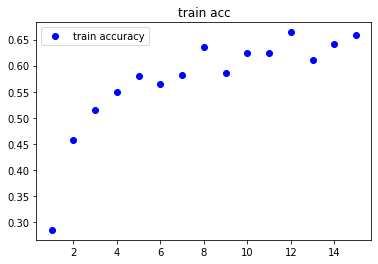

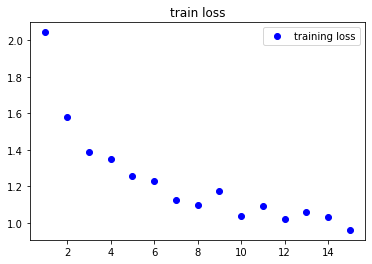

In [11]:
history = model.fit_generator(train_generator,
            steps_per_epoch=80, 
			epochs=15,
            validation_data=validation_generator,
            validation_steps=8)

acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.title('train loss')
plt.legend()

plt.show()

## Test the Model

In [12]:
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_path,
					target_size = (WIDTH, HEIGHT),
					batch_size = 1367,
					class_mode= 'categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps = 1)
print('\ntest acc :\n', test_acc)

# Carpeta donde no hay suficientes imagenes como el batch_size
# Era el steps * batch_size

Found 1367 images belonging to 11 classes.


c:\Users\Rafael\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



test acc :
 0.536942183971405


In [13]:
test_images = test_generator[0][0]
test_labels = test_generator[0][1]

predictions = model.predict(test_images)
predictions
classes_x = np.argmax(predictions,axis=1)
classes_x

test_labels = np.argmax(test_labels, axis = 1)
test_labels


# Ok... si , ya vimos que el predictions es un vector de vectores. Y pues cada vector es de tamaño 11. 
# El predictions tiene 0s y 1s y al final de cuentas los 0 indican que la foto pertenece a esa clase o no

array([0, 7, 8, ..., 4, 6, 9], dtype=int64)

In [35]:
from tensorflow.math import confusion_matrix

# Ambos arreglos deben tener las mismas dimensiones
# predictions tiene [2, 11]. p
mat = confusion_matrix(classes_x, test_labels)
mat

<tf.Tensor: shape=(11, 11), dtype=int32, numpy=
array([[118,   4,  58,  46,  63,  20,  39,  12,   9,  66,  37],
       [  2, 158,   1,   4,   2,  21,  12,  26,  45,  61,  16],
       [ 14,   1,  31,  62,  27,   8,  42,   0,  60,   1,  36],
       [  2,   4,   5,  14,  15,   5,  11,   1,  60,   4,  23],
       [  2,   0,   0,   0,  11,  12,   1,   4,  12,   0,   5],
       [  0,   0,   0,   0,   0,   4,   0,   0,   0,   0,   0],
       [  1,   2,   0,   1,   0,   2,   0,   2,  36,   1,   6],
       [  0,   0,   0,   0,   0,   0,   0,   0,   5,   1,   0],
       [  0,   0,   0,   0,   0,   3,   0,   1,   5,   4,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [14]:
print('There were ' + str(len(os.listdir(augmented_path))) + ' augmented images generated.')

There were 38872 augmented images generated.


#### Análisis de resultados

Se observa de la siguiente gráfica que el train accuracy fue del 66.42%, casi 10% más que sin VGG. En contraparte, el test_accuracy fue del 53.69%, 2% menos que sin VGG. La diferencia de ambas métricas es de 12.63%, lo cual indica que hay underfitting, al ser la diferencia relativamente grande. 

Basándondos en el estado del arte, la mejor accuracy ronda el 80%, por lo que aún no es un modelo óptimo ni cercano a lo que podemos esperar.

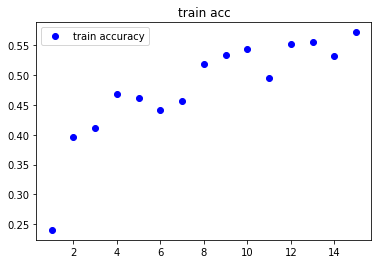

Basado en experimentos previos, el escenario en el que la accuracy supera el 63% es cuando el número de épocas es de aproximadamente 60. 

Los próximos pasos se basarán en analizar la arquitectura empleada y los parámetros utilizados para optimizar el modelo y obtener una accuracy lo más alta posible para testing.

Rafael Hinojosa López

A01705777

26 de mayo del 2023

TC2003B Actividad 2.2 Preprocesado de los datos